In [ ]:
!pip install XGBoost
!pip install catboost
!pip install optuna
!pip install LightGBM
!pip install optuna-integration[lightgbm]
import pandas as pd
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


In [ ]:
from sklearn.model_selection import train_test_split
df_m_train = pd.read_csv("train_Mortgage.csv")
df_p_train = pd.read_csv("train_Pension.csv")
df_s_train = pd.read_csv("train_Savings.csv")
target_name_1 = "Mortgage"
target_name_2 = "Pension"
target_name_3 = "Savings"
y_train_m = df_m_train[target_name_1]
y_train_p = df_p_train[target_name_2]
y_train_s = df_s_train[target_name_3]
X_train_m = df_m_train.drop(columns=[target_name_1])
X_train_p = df_p_train.drop(columns=[target_name_2])
X_train_s = df_s_train.drop(columns=[target_name_3])

In [ ]:
df_m_valid = pd.read_csv("val_Mortgage.csv")
df_p_valid = pd.read_csv("val_Pension.csv")
df_s_valid = pd.read_csv("val_Savings.csv")
y_test_m = df_m_valid[target_name_1]
y_test_p = df_p_valid[target_name_2]
y_test_s = df_s_valid[target_name_3]
X_test_m = df_m_valid.drop(columns=[target_name_1])
X_test_p = df_p_valid.drop(columns=[target_name_2])
X_test_s = df_s_valid.drop(columns=[target_name_3])

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    roc_curve,
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def evaluate_models(model_1, model_2, model_3, X_test, y_test,target, pos_label='yes'):
    """
    Вычисляет метрики и строит график AUC для модели CatBoostClassifier.

    Параметры:
        model1:
        model2:
        model3:
        X_test: Тестовые данные (признаки).
        y_test: Истинные значения целевой переменной.

    Возвращает:
        Словарь с метриками: accuracy, f1_score, roc_auc, precision, recall.
    """

    # Предсказание вероятностей и классов
    y_pred_proba_1 = model_1.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_1 = model_1.predict(X_test)  # Предсказанные классы
    y_pred_proba_2 = model_2.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_2 = model_2.predict(X_test)  # Предсказанные классы
    y_pred_proba_3 = model_3.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred_3 = model_3.predict(X_test)  # Предсказанные классы

    fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba_1)
    roc_auc_1 = auc(fpr1, tpr1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba_2)
    roc_auc_2 = auc(fpr2, tpr2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_3)
    roc_auc_3 = auc(fpr3, tpr3)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 7))
    sns.lineplot(x=fpr1, y=tpr1, label=f'LightGBM (AUC = {roc_auc_1:.6f})', color='blue')
    sns.lineplot(x=fpr2, y=tpr2, label=f'CatBoost (AUC = {roc_auc_2:.6f})', color='green')
    sns.lineplot(x=fpr3, y=tpr3, label=f'XGBoost (AUC = {roc_auc_3:.6f})', color='red')

    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

    # Настраиваем график
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC for ' + target)
    plt.legend(loc='lower right')
    plt.show()

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

class FeatureAttention(nn.Module):
    def __init__(self, input_dim, units):
        super(FeatureAttention, self).__init__()
        self.units = units
        self.query = nn.Linear(input_dim, units)
        self.key = nn.Linear(input_dim, units)
        self.value = nn.Linear(input_dim, units)
        self.attention_weights = None

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.units, dtype=torch.float32))
        self.attention_weights = F.softmax(attention_scores, dim=-1)
        output = torch.matmul(self.attention_weights, V)
        return output

class FiNetWithAttention(nn.Module):
    def __init__(self, input_dim, num_blocks=3, hidden_units=64, dropout_rate=0.2):
        super(FiNetWithAttention, self).__init__()
        self.input_dim = input_dim
        self.num_blocks = num_blocks
        self.hidden_units = hidden_units

        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.LayerNorm(hidden_units)
        )

        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            block = nn.ModuleDict({
                'attention': FeatureAttention(hidden_units, hidden_units),
                'dense1': nn.Linear(hidden_units, hidden_units),
                'dense2': nn.Linear(hidden_units, hidden_units),
                'ln': nn.LayerNorm(hidden_units),
                'dropout': nn.Dropout(dropout_rate)
            })
            self.blocks.append(block)

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_units, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)

        for block in self.blocks:
            attn_out = block['attention'](x)
            attn_out = block['dense1'](attn_out)
            attn_out = F.relu(attn_out)

            x_interaction = x * attn_out
            x_interaction = block['dense2'](x_interaction)
            x_interaction = F.relu(x_interaction)

            x = x + x_interaction
            x = block['ln'](x)
            x = block['dropout'](x)

        return self.output_layer(x)

    def get_attention_weights(self):
        """Возвращает веса внимания из всех блоков"""
        return [block['attention'].attention_weights for block in self.blocks]

# Функция для подготовки данных
def prepare_data(X_train, y_train):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Convert target to float tensor (binary classification)
    y_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    return X_tensor, y_tensor, scaler

# Инициализация моделей для каждой задачи
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {
    'mortgage': FiNetWithAttention(X_train_m.shape[1]).to(device),
    'pension': FiNetWithAttention(X_train_p.shape[1]).to(device),
    'savings': FiNetWithAttention(X_train_s.shape[1]).to(device)
}

# Подготовка данных для каждой задачи
X_m, y_m, scaler_m = prepare_data(X_train_m, y_train_m)
X_p, y_p, scaler_p = prepare_data(X_train_p, y_train_p)
X_s, y_s, scaler_s = prepare_data(X_train_s, y_train_s)

# Создание DataLoader
batch_size = 64
train_m = TensorDataset(X_m, y_m)
train_p = TensorDataset(X_p, y_p)
train_s = TensorDataset(X_s, y_s)

train_loader_m = DataLoader(train_m, batch_size=batch_size, shuffle=True)
train_loader_p = DataLoader(train_p, batch_size=batch_size, shuffle=True)
train_loader_s = DataLoader(train_s, batch_size=batch_size, shuffle=True)

# Функция обучения для бинарной классификации
def train_model(model, train_loader, epochs=20):
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = torch.optim.Adam(model.parameters())

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

# Обучение моделей
print("Training Mortgage model...")
train_model(models['mortgage'], train_loader_m)

print("\nTraining Pension model...")
train_model(models['pension'], train_loader_p)

print("\nTraining Savings model...")
train_model(models['savings'], train_loader_s)

# Функция для извлечения признаков (перед последним слоем)
def extract_features(model, X, scaler):
    X_scaled = scaler.transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

    # Получаем выход перед последним Sigmoid слоем
    model.eval()
    with torch.no_grad():
        # Проходим через все слои, кроме последнего Sigmoid
        x = model.embedding(X_tensor)
        for block in model.blocks:
            attn_out = block['attention'](x)
            attn_out = block['dense1'](attn_out)
            attn_out = F.relu(attn_out)

            x_interaction = x * attn_out
            x_interaction = block['dense2'](x_interaction)
            x_interaction = F.relu(x_interaction)

            x = x + x_interaction
            x = block['ln'](x)
            x = block['dropout'](x)

        features = x.cpu().numpy()
    return features

# Извлечение признаков для бустинга
X_train_m_features = extract_features(models['mortgage'], X_train_m, scaler_m)
X_train_p_features = extract_features(models['pension'], X_train_p, scaler_p)
X_train_s_features = extract_features(models['savings'], X_train_s, scaler_s)

Training Mortgage model...
Epoch 1/20, Loss: 0.3155, Accuracy: 85.50%
Epoch 2/20, Loss: 0.2306, Accuracy: 88.82%
Epoch 3/20, Loss: 0.2184, Accuracy: 89.24%
Epoch 4/20, Loss: 0.2145, Accuracy: 89.50%
Epoch 5/20, Loss: 0.2105, Accuracy: 89.62%
Epoch 6/20, Loss: 0.2070, Accuracy: 89.66%
Epoch 7/20, Loss: 0.2013, Accuracy: 90.04%
Epoch 8/20, Loss: 0.1995, Accuracy: 90.20%
Epoch 9/20, Loss: 0.2020, Accuracy: 90.02%
Epoch 10/20, Loss: 0.1995, Accuracy: 90.24%
Epoch 11/20, Loss: 0.1970, Accuracy: 90.33%
Epoch 12/20, Loss: 0.1964, Accuracy: 89.83%
Epoch 13/20, Loss: 0.1936, Accuracy: 90.38%
Epoch 14/20, Loss: 0.1936, Accuracy: 89.99%
Epoch 15/20, Loss: 0.1941, Accuracy: 90.22%
Epoch 16/20, Loss: 0.1923, Accuracy: 90.47%
Epoch 17/20, Loss: 0.1890, Accuracy: 90.52%
Epoch 18/20, Loss: 0.1875, Accuracy: 90.56%
Epoch 19/20, Loss: 0.1872, Accuracy: 90.59%
Epoch 20/20, Loss: 0.1905, Accuracy: 90.25%

Training Pension model...
Epoch 1/20, Loss: 0.4910, Accuracy: 75.04%
Epoch 2/20, Loss: 0.4536, Accura

In [ ]:
# Извлечение признаков для бустинга
X_train_m_features = extract_features(models['mortgage'], X_train_m, scaler_m)
X_train_p_features = extract_features(models['pension'], X_train_p, scaler_p)
X_train_s_features = extract_features(models['savings'], X_train_s, scaler_s)

In [ ]:
from xgboost import XGBClassifier

# Для Mortgage
xgb_m = XGBClassifier()
xgb_m.fit(X_train_m_features, y_train_m)

# Для Pension
xgb_p = XGBClassifier()
xgb_p.fit(X_train_p_features, y_train_p)

# Для Savings
xgb_s = XGBClassifier()
xgb_s.fit(X_train_s_features, y_train_s)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
from xgboost import XGBClassifier

# Для Mortgage
c_m = CatBoostClassifier()
c_m.fit(X_train_m_features, y_train_m, verbose=0)

# Для Pension
c_p = CatBoostClassifier()
c_p.fit(X_train_p_features, y_train_p, verbose=0)

# Для Savings
c_s = CatBoostClassifier()
c_s.fit(X_train_s_features, y_train_s, verbose=0)

In [ ]:
from xgboost import XGBClassifier

# Для Mortgage
l_m = LGBMClassifier()
l_m.fit(X_train_m_features, y_train_m)

# Для Pension
l_p = LGBMClassifier()
l_p.fit(X_train_p_features, y_train_p)

# Для Savings
l_s = LGBMClassifier()
l_s.fit(X_train_s_features, y_train_s)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier()

In [ ]:
X_test_m_features = extract_features(models['mortgage'], X_test_m, scaler_m)
X_test_p_features = extract_features(models['pension'], X_test_p, scaler_p)
X_test_s_features = extract_features(models['savings'], X_test_s, scaler_s)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


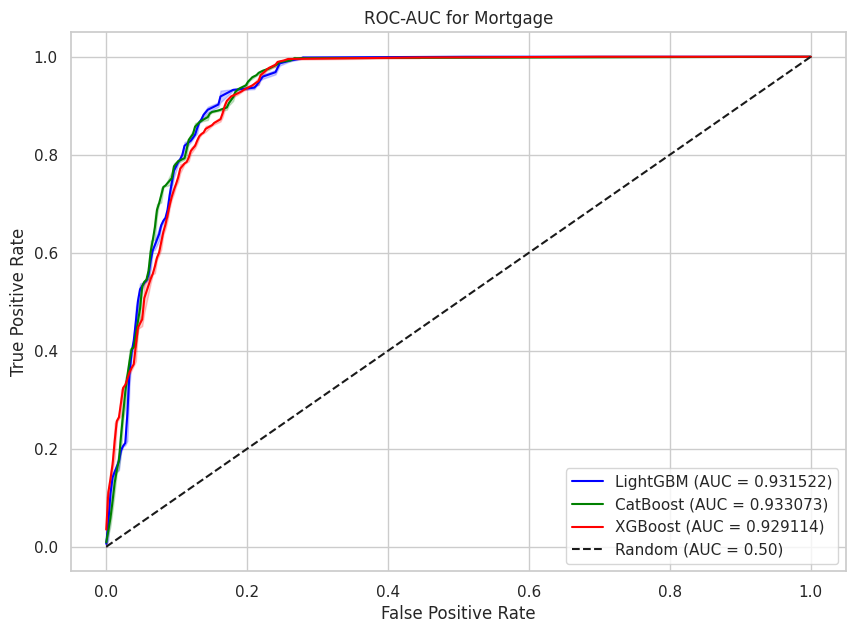

In [ ]:
evaluate_models(l_m, c_m, xgb_m, X_test_m_features, y_test_m, "Mortgage", pos_label=1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


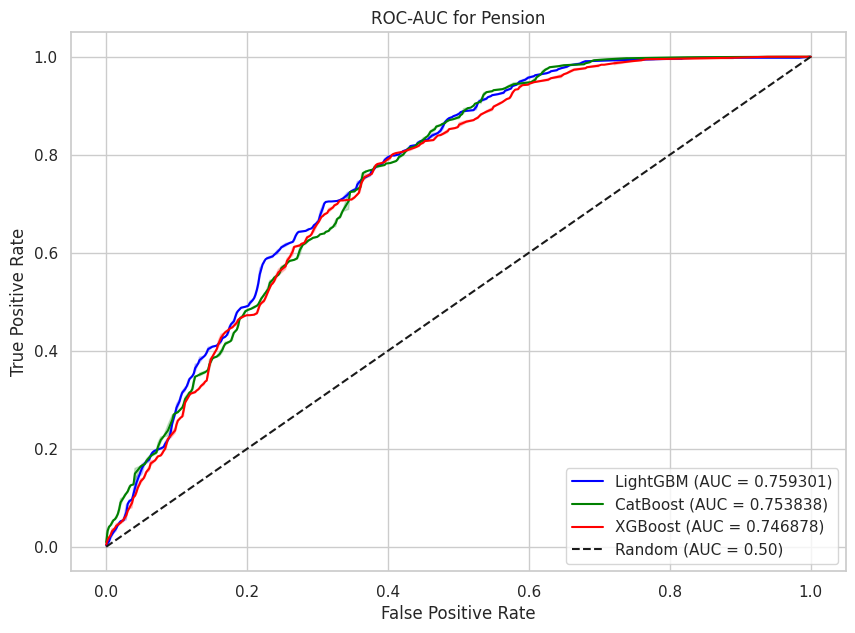

In [ ]:
evaluate_models(l_p, c_p, xgb_p, X_test_p_features, y_test_p, "Pension", pos_label=1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


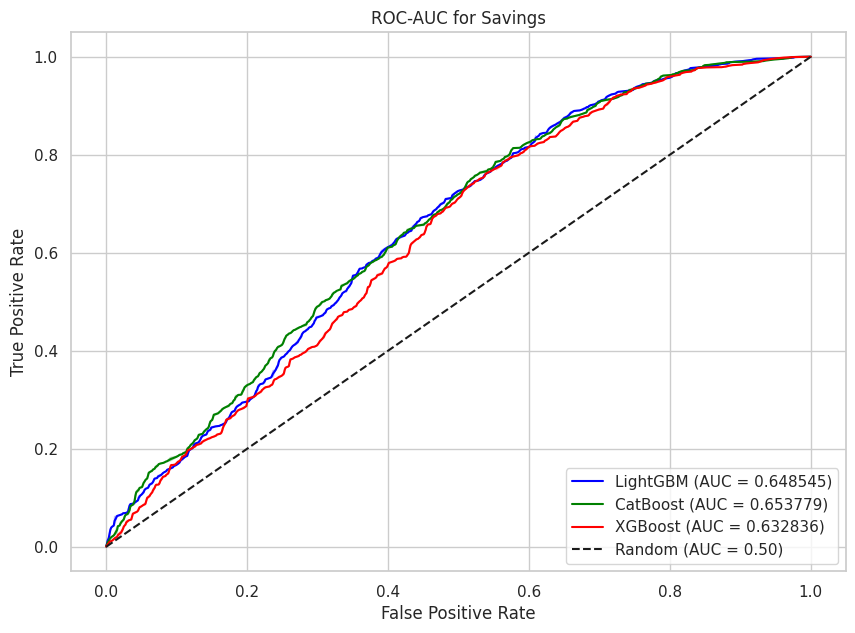

In [ ]:
evaluate_models(l_s, c_s, xgb_s, X_test_s_features, y_test_s, "Savings", pos_label=1)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
X_train_m_features, X_valid_m, y_train_m, y_valid_m = train_test_split(X_train_m_features, y_train_m, test_size = 0.15, stratify=y_train_m)
X_train_p_features, X_valid_p, y_train_p, y_valid_p = train_test_split(X_train_p_features, y_train_p, test_size = 0.15, stratify=y_train_p)
X_train_s_features, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_s_features, y_train_s, test_size = 0.15, stratify=y_train_s)



In [ ]:
def optimizers(model_lib,X_train, y_train, X_valid, y_valid, n_trials=10, timeout=60*3):
  def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'tree_method': 'hist',
        'random_state': 42,
    }
    model = model_lib(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, timeout=timeout)
  return study.best_params

from optuna.pruners import HyperbandPruner
from optuna.integration import LightGBMPruningCallback

def optimize_lgbm(model_lib, X_train, y_train, X_valid, y_valid, n_trials=10):
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 50, 1400),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': -1,
            'early_stopping_rounds': 20,# Отключаем логи LightGBM
        }

        pruning_callback = LightGBMPruningCallback(
            trial,
            metric='auc',
            valid_name='valid_0',
        )

        model = model_lib(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],  # Обязательно передаем eval_set
            callbacks=[pruning_callback],    # Передаем callback
            #early_stopping_rounds=20,        # Ранняя остановка
            #verbose=False                    # Отключаем вывод
        )

        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        return roc_auc_score(y_valid, y_pred_proba)

    # Настройка HyperbandPruner
    study = optuna.create_study(
        direction='maximize',  # Для roc_auc_score
        pruner=optuna.pruners.HyperbandPruner()
    )
    study.optimize(objective, timeout=60*3)
    return study.best_params

def optimizers_catboost(X_train, y_train, X_valid, y_valid, n_trials=10):
  def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 50, 1400),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2,0.7),
        "max_depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        'verbose': False,
        'random_state': 42,
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, timeout=3*60)
  return study.best_params

In [ ]:
X_train_m_features.shape, y_train_m.shape

((6370, 64), (6370,))

In [ ]:
best_m_XGBoost = optimizers(XGBClassifier, X_train_m_features, y_train_m, X_valid_m, y_valid_m)
best_m_CatBoost = optimizers_catboost(X_train_m_features, y_train_m, X_valid_m, y_valid_m, n_trials = 30)
best_m_LightGBM = optimize_lgbm(LGBMClassifier, X_train_m_features, y_train_m, X_valid_m, y_valid_m, n_trials = 500)

[I 2025-04-18 11:55:38,013] A new study created in memory with name: no-name-5c777c25-34f8-49ee-9633-4bc0979349d7
[I 2025-04-18 11:55:39,927] Trial 0 finished with value: 0.9463134461264471 and parameters: {'n_estimators': 1174, 'max_depth': 13, 'learning_rate': 0.2915010655482251, 'subsample': 0.6438904864679833, 'colsample_bytree': 0.6302071023970335, 'min_child_weight': 9, 'gamma': 0.9623205364321891, 'reg_alpha': 2.417279054961834, 'reg_lambda': 1.312305360173699, 'scale_pos_weight': 8.75720851613464}. Best is trial 0 with value: 0.9463134461264471.
[I 2025-04-18 11:55:41,208] Trial 1 finished with value: 0.947439893143366 and parameters: {'n_estimators': 752, 'max_depth': 15, 'learning_rate': 0.23683318916932114, 'subsample': 0.7326822445975946, 'colsample_bytree': 0.9338823705997701, 'min_child_weight': 4, 'gamma': 1.6976792685069624, 'reg_alpha': 0.6971173876995063, 'reg_lambda': 3.380263453815422, 'scale_pos_weight': 4.893562071202106}. Best is trial 1 with value: 0.94743989314

0:	learn: 0.6634517	total: 3.52ms	remaining: 1.32s
250:	learn: 0.1718940	total: 762ms	remaining: 376ms
374:	learn: 0.1664785	total: 1.14s	remaining: 0us


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


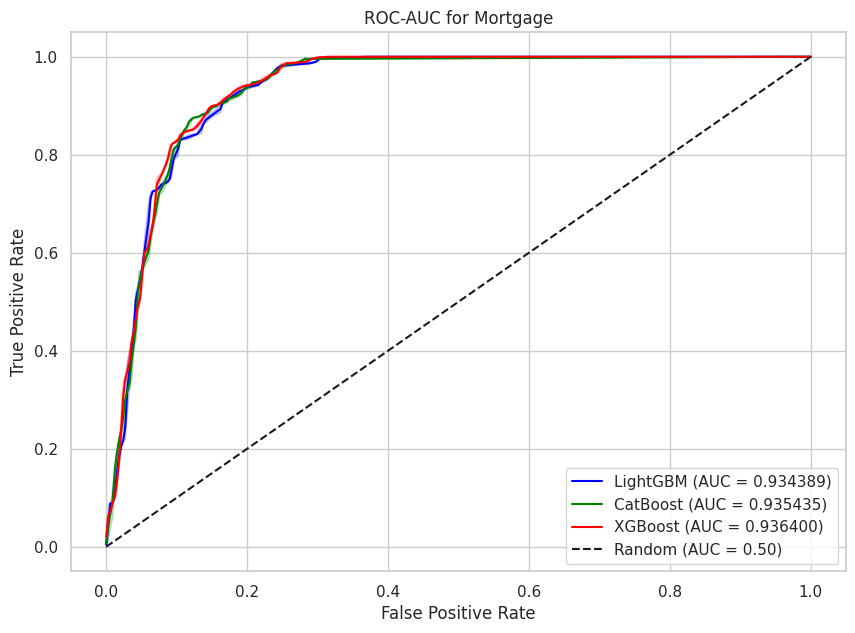

In [ ]:
best_model_m_xg = XGBClassifier(**best_m_XGBoost)
best_model_m_xg.fit(X_train_m_features, y_train_m)
best_model_m_с = CatBoostClassifier(**best_m_CatBoost, verbose=250)
best_model_m_с.fit(X_train_m_features, y_train_m)
best_model_m_l = LGBMClassifier(**best_m_LightGBM, verbose=-1)
best_model_m_l.fit(X_train_m_features,y_train_m)
evaluate_models(best_model_m_l, best_model_m_с, best_model_m_xg, X_test_m_features, y_test_m,"Mortgage", pos_label=1)

In [ ]:
best_p_XGBoost = optimizers(XGBClassifier, X_train_p_features, y_train_p, X_valid_p, y_valid_p)
best_p_CatBoost = optimizers_catboost(X_train_p_features, y_train_p, X_valid_p, y_valid_p, n_trials = 30)
best_p_LightGBM = optimize_lgbm(LGBMClassifier, X_train_p_features, y_train_p, X_valid_p, y_valid_p, n_trials = 500)

[I 2025-04-18 12:06:20,628] A new study created in memory with name: no-name-c58d9b9d-045d-4f89-96fe-4110b6d9e3da
[I 2025-04-18 12:06:23,208] Trial 0 finished with value: 0.7554820945723143 and parameters: {'n_estimators': 480, 'max_depth': 3, 'learning_rate': 0.021092102102228533, 'subsample': 0.5395126573648817, 'colsample_bytree': 0.7895924851970009, 'min_child_weight': 1, 'gamma': 3.277978346496101, 'reg_alpha': 7.332525696267272, 'reg_lambda': 7.511879022803298, 'scale_pos_weight': 9.36645647253043}. Best is trial 0 with value: 0.7554820945723143.
[I 2025-04-18 12:06:30,192] Trial 1 finished with value: 0.7455005605750842 and parameters: {'n_estimators': 901, 'max_depth': 9, 'learning_rate': 0.011291247838362783, 'subsample': 0.8056274853186829, 'colsample_bytree': 0.5979321775891439, 'min_child_weight': 9, 'gamma': 4.786899869399322, 'reg_alpha': 7.675585835630862, 'reg_lambda': 6.5174467107319325, 'scale_pos_weight': 9.940052035221619}. Best is trial 0 with value: 0.755482094572

0:	learn: 0.6846546	total: 23.9ms	remaining: 20.6s
250:	learn: 0.4259724	total: 3.2s	remaining: 7.82s
500:	learn: 0.4171876	total: 5.62s	remaining: 4.07s
750:	learn: 0.4146013	total: 7.8s	remaining: 1.17s
863:	learn: 0.4134242	total: 9.1s	remaining: 0us


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


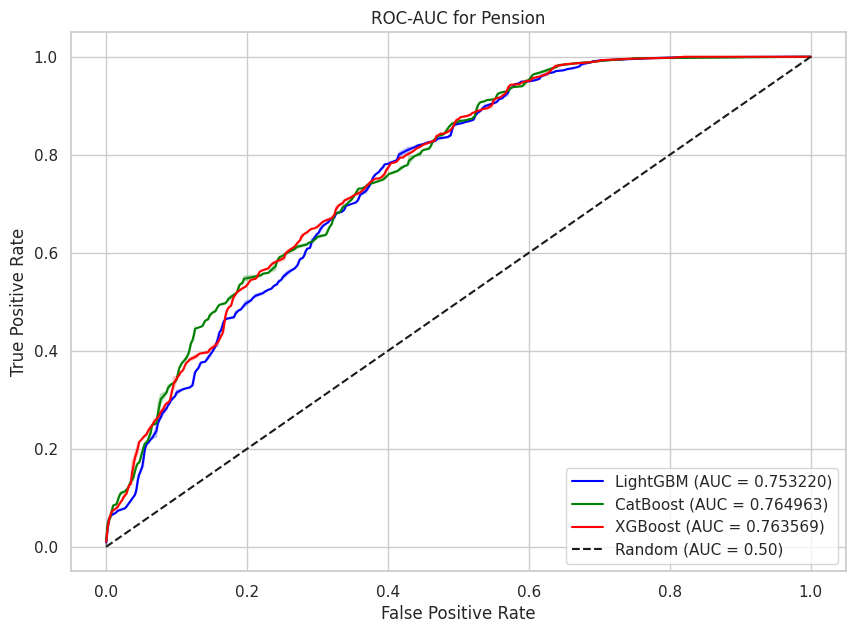

In [ ]:
best_model_p_xg = XGBClassifier(**best_p_XGBoost)
best_model_p_xg.fit(X_train_p_features, y_train_p)
best_model_p_с = CatBoostClassifier(**best_p_CatBoost, verbose=250)
best_model_p_с.fit(X_train_p_features, y_train_p)
best_model_p_l = LGBMClassifier(**best_p_LightGBM, verbose=-1)
best_model_p_l.fit(X_train_p_features,y_train_p)
evaluate_models(best_model_p_l, best_model_p_с, best_model_p_xg, X_test_p_features, y_test_p,"Pension", pos_label=1)

In [ ]:
best_s_XGBoost = optimizers(XGBClassifier, X_train_s_features, y_train_s, X_valid_s, y_valid_s)
best_s_CatBoost = optimizers_catboost(X_train_s_features, y_train_s, X_valid_s, y_valid_s, n_trials = 30)
best_s_LightGBM = optimize_lgbm(LGBMClassifier, X_train_s_features, y_train_s, X_valid_s, y_valid_s, n_trials = 500)

[I 2025-04-18 12:16:55,744] A new study created in memory with name: no-name-baa237ff-36b3-4709-915d-64eefd09af24
[I 2025-04-18 12:16:56,603] Trial 0 finished with value: 0.6843371717523301 and parameters: {'n_estimators': 1121, 'max_depth': 15, 'learning_rate': 0.2595982316510757, 'subsample': 0.9745606887217532, 'colsample_bytree': 0.5049981570852085, 'min_child_weight': 10, 'gamma': 4.231078673668044, 'reg_alpha': 6.040985569223174, 'reg_lambda': 0.898025898318755, 'scale_pos_weight': 5.642623575584583}. Best is trial 0 with value: 0.6843371717523301.
[I 2025-04-18 12:17:04,840] Trial 1 finished with value: 0.6209307440925087 and parameters: {'n_estimators': 1326, 'max_depth': 8, 'learning_rate': 0.21361315140677145, 'subsample': 0.5582953529169792, 'colsample_bytree': 0.7465925312519195, 'min_child_weight': 6, 'gamma': 1.1618960563915226, 'reg_alpha': 0.7891759452915992, 'reg_lambda': 5.6355516426914445, 'scale_pos_weight': 9.754635569132438}. Best is trial 0 with value: 0.68433717

0:	learn: 0.6895224	total: 17.7ms	remaining: 19.9s
250:	learn: 0.5950312	total: 2.05s	remaining: 7.12s
500:	learn: 0.5905439	total: 3.9s	remaining: 4.85s
750:	learn: 0.5888449	total: 5.8s	remaining: 2.88s
1000:	learn: 0.5879177	total: 7.61s	remaining: 935ms
1123:	learn: 0.5876220	total: 8.52s	remaining: 0us


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


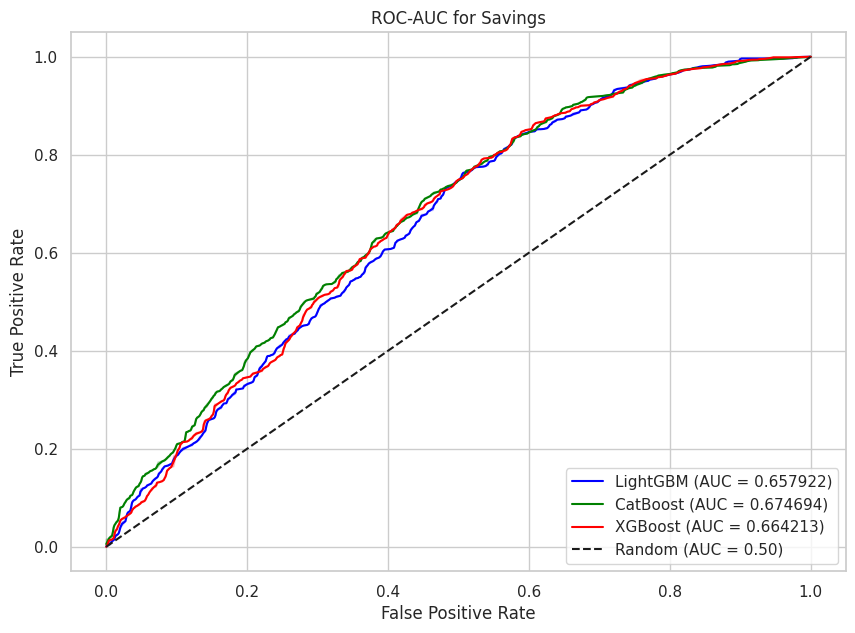

In [ ]:
best_model_s_xg = XGBClassifier(**best_s_XGBoost)
best_model_s_xg.fit(X_train_s_features, y_train_s)
best_model_s_с = CatBoostClassifier(**best_s_CatBoost, verbose=250)
best_model_s_с.fit(X_train_s_features, y_train_s)
best_model_s_l = LGBMClassifier(**best_s_LightGBM, verbose=-1)
best_model_s_l.fit(X_train_s_features,y_train_s)
evaluate_models(best_model_s_l, best_model_s_с, best_model_s_xg, X_test_s_features, y_test_s,"Savings", pos_label=1)

In [86]:

# Получить веса внимания для конкретного батча
models['mortgage'].eval()
with torch.no_grad():
    test_input = torch.randn(1, X_train_m.shape[1]).to(device)  # Пример входных данных
    output = models['mortgage'](test_input)
    attention_weights = models['mortgage'].get_attention_weights()  # Список весов для каждого блока

# Визуализация весов первого блока
print("Attention weights for first block:")
attention_weights

Attention weights for first block:


[tensor([[1.]], device='cuda:0'),
 tensor([[1.]], device='cuda:0'),
 tensor([[1.]], device='cuda:0')]